<a href="https://colab.research.google.com/github/jonboyd94/CNN_Handwritten_Digits/blob/main/Handwritten_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [77]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import datasets, transforms
from PIL import Image
import pandas as pd
import os
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import cv2
from IPython.display import display
import ipywidgets as widgets


In [15]:
#convert to tensor
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load MNIST
mnist_train = datasets.MNIST(root="./data", train=True, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.06MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 134kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.41MB/s]


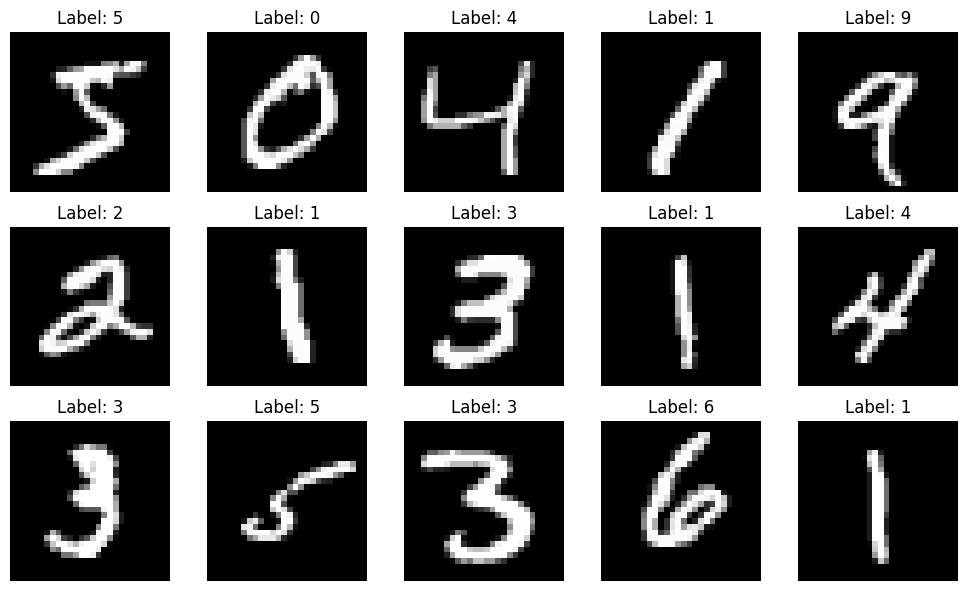

In [16]:
# Plot first 15 digits
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.flatten()

for i in range(15):
    image, label = mnist_train[i]
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()



In [37]:
#Clone repo that has digits and labels
!git clone https://github.com/jonboyd94/CNN_Handwritten_Digits.git



fatal: destination path 'CNN_Handwritten_Digits' already exists and is not an empty directory.


In [36]:
# Custom dataset to read data and set path
class CustomDigitDataset(Dataset):
    def __init__(self, csv_path, image_dir, transform=None):
        self.data = pd.read_csv(csv_path)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    # Build image path from label by reading label from CSV
    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.data.iloc[idx, 0])
        label = int(self.data.iloc[idx, 1])
        image = Image.open(img_path).convert("L")  # convert to grayscale

        # Invert image to match MNIST
        image = TF.invert(image)

        if self.transform:
            image = self.transform(image)
        return image, label

# resize to 28x28, grayscale, convert to tensor [1, 28, 28]
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

# Set paths
csv_path = "/content/CNN_Handwritten_Digits/cropped_annotations2.csv"
image_dir = "/content/CNN_Handwritten_Digits/cropped_digits"

# Create dataset and DataLoader
custom_dataset = CustomDigitDataset(csv_path=csv_path, image_dir=image_dir, transform=transform)
loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

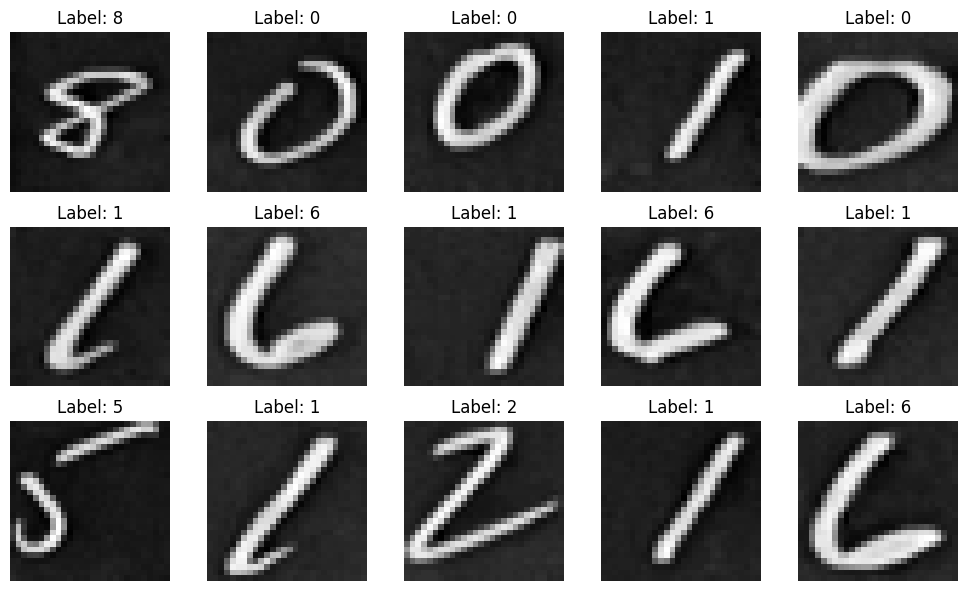

In [20]:
fig, axes = plt.subplots(3, 5, figsize=(10, 6))
axes = axes.flatten()

for i in range(15):
    image, label = custom_dataset[i]
    axes[i].imshow(image.squeeze(), cmap="gray")
    axes[i].set_title(f"Label: {label}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()


In [24]:
# Combine MNIST and custom dataset
combined_dataset = ConcatDataset([mnist_train, custom_dataset])

# Split data (80% train, 20% val)
train_size = int(0.8 * len(combined_dataset))
val_size = len(combined_dataset) - train_size

train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])


In [33]:
BATCH_SIZE = 128

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


In [34]:
class DigitCNN(nn.Module):
    def __init__(self):
        super(DigitCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1) #1 channel, 32 filters, 3x3 kernel, stride = 1
        self.conv2 = nn.Conv2d(32, 64, 3, 1)#32 features, outputs 64
        self.dropout1 = nn.Dropout(0.25) #dropout to help with overfitting
        self.fc1 = nn.Linear(9216, 128) #fully connected, 4 channels × 12 × 12 = 9216
        self.fc2 = nn.Linear(128, 10) #Final layer, 128 features to 10 class scores

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2) #2×2 max pooling (downsamples from 24×24 to 2×12)
        x = self.dropout1(x) #regularization dropoutu
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [31]:
model = DigitCNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()


In [41]:
EPOCHS = 10

#training
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

#validation
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            output = model(images)
            val_loss += criterion(output, labels).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(labels.view_as(pred)).sum().item()

    val_loss /= len(val_loader). #Average validation loss over all batches
    val_acc = 100. * correct / len(val_loader.dataset) #as percentage
    print(f"Epoch {epoch+1} | Train Loss: {total_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")


Epoch 1 | Train Loss: 92.8594 | Val Loss: 0.0747 | Val Acc: 97.74%
Epoch 2 | Train Loss: 22.5498 | Val Loss: 0.0483 | Val Acc: 98.61%
Epoch 3 | Train Loss: 14.9554 | Val Loss: 0.0424 | Val Acc: 98.72%
Epoch 4 | Train Loss: 11.0803 | Val Loss: 0.0404 | Val Acc: 98.71%
Epoch 5 | Train Loss: 8.4569 | Val Loss: 0.0401 | Val Acc: 98.76%
Epoch 6 | Train Loss: 6.8762 | Val Loss: 0.0511 | Val Acc: 98.60%
Epoch 7 | Train Loss: 4.8855 | Val Loss: 0.0408 | Val Acc: 98.88%
Epoch 8 | Train Loss: 4.1420 | Val Loss: 0.0421 | Val Acc: 98.89%
Epoch 9 | Train Loss: 4.1565 | Val Loss: 0.0407 | Val Acc: 98.96%
Epoch 10 | Train Loss: 3.4344 | Val Loss: 0.0444 | Val Acc: 98.87%


In [42]:
torch.save(model.state_dict(), "digit_cnn.pth")


<Figure size 800x800 with 0 Axes>

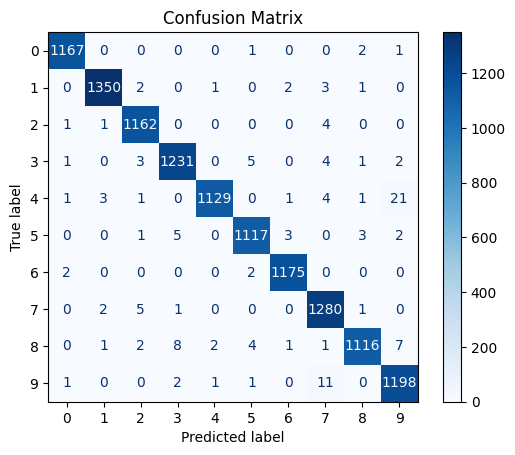

In [46]:
#Confusion Matrix

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:  # or test_loader
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(range(10)))

plt.figure(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()


In [15]:
#model = DigitCNN()
#model.load_state_dict(torch.load("digit_cnn.pth"))
#model.eval()

Predicted digit: 1 — from file: digit_020_label_1.png


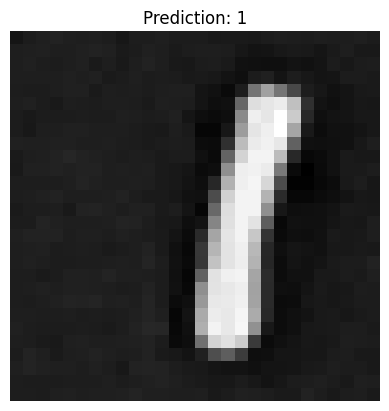

In [68]:
# Set folder path
folder_path = "CNN_Handwritten_Digits/cropped_digits"

# Choose a random image file
image_file = random.choice([f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
image_path = os.path.join(folder_path, image_file)

# Load and preprocess image
image = Image.open(image_path).convert("L")
image = TF.invert(image)  # invert to match MNIST

transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(input_tensor)
    prediction = output.argmax(dim=1, keepdim=True).item()

# Show prediction
print(f"Predicted digit: {prediction} — from file: {image_file}")

# Show image
plt.imshow(input_tensor.squeeze().cpu(), cmap='gray')
plt.title(f"Prediction: {prediction}")
plt.axis('off')
plt.show()


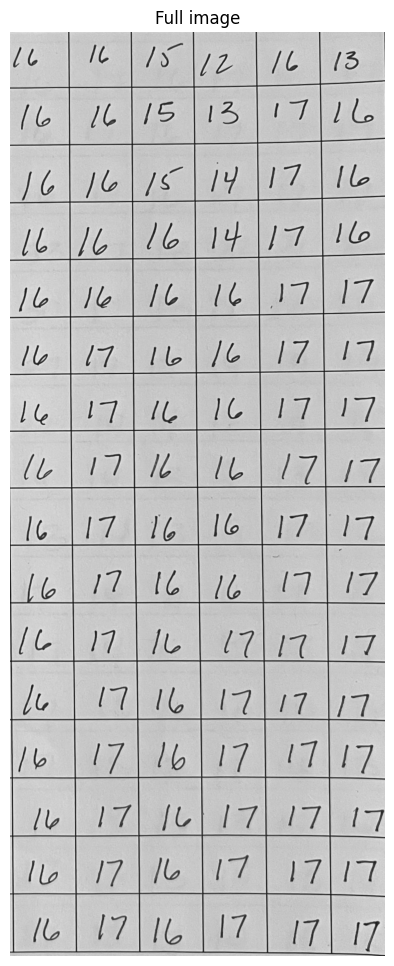

In [70]:
# Load full image
image_path = "/content/CNN_Handwritten_Digits/Digits_cropped.jpg"
image = Image.open(image_path).convert("L")  #grayscale

# Show the image
plt.figure(figsize=(12, 12))
plt.imshow(image, cmap='gray')
plt.title("Full image")
plt.axis('off')
plt.show()



In [94]:
#Load form & model
full = cv2.imread("/content/CNN_Handwritten_Digits/Digits_cropped.jpg", cv2.IMREAD_GRAYSCALE)
H, W = full.shape

model = DigitCNN().to(device)
model.load_state_dict(torch.load("digit_cnn.pth", map_location=device))
model.eval()

to_tensor = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(1),
    transforms.Resize((28,28)),
    transforms.ToTensor(),
])

# prediction cell. Make gridlines with margin to remmove lines from original image
def predict_cell(cell, area_thresh, min_as, max_as, margin):
    h, w = cell.shape
    crop = cell[margin:h-margin, margin:w-margin]
    blur = cv2.GaussianBlur(crop, (5,5), 0)
    _, thr = cv2.threshold(blur, 0, 255,
        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    thr = cv2.morphologyEx(thr, cv2.MORPH_CLOSE,
        cv2.getStructuringElement(cv2.MORPH_RECT,(3,3)))
    cnts, _ = cv2.findContours(thr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    boxes = []
    for c in cnts:
        x,y,ww,hh = cv2.boundingRect(c)
        if ww*hh < area_thresh: continue
        ar = ww/float(hh)
        if ar < min_as or ar > max_as: continue
        boxes.append((x,y,ww,hh))
    if not boxes:
        return ""
    boxes.sort(key=lambda b: b[0])

    digits = []
    for x,y,ww,hh in boxes:
        roi = thr[y:y+hh, x:x+ww]
        S = max(ww, hh)
        sq = np.zeros((S,S), np.uint8)
        dx, dy = (S-ww)//2, (S-hh)//2
        sq[dy:dy+hh, dx:dx+ww] = roi
        im28 = cv2.resize(sq, (28,28))
        t = to_tensor(im28).unsqueeze(0).to(device)
        with torch.no_grad():
            p = model(t).argmax(1).item()
        digits.append(str(p))
    return "".join(digits)

# Grid sliders
x_start_sl = widgets.IntSlider(value=0, min=0, max=W, step=1, description='x_start')
x_end_sl   = widgets.IntSlider(value=W, min=0, max=W, step=1, description='x_end')
y_start_sl = widgets.IntSlider(value=0, min=0, max=H, step=1, description='y_start')
y_end_sl   = widgets.IntSlider(value=H, min=0, max=H, step=1, description='y_end')

#Digit-param sliders
margin_sl       = widgets.IntSlider(value=2,   min=0,   max=20,  step=1,  description='margin')
area_thresh_sl  = widgets.IntSlider(value=80,  min=10,  max=500, step=10, description='min_area')
min_aspect_sl   = widgets.FloatSlider(value=0.3, min=0.1, max=1.0, step=0.05, description='min_aspect')
max_aspect_sl   = widgets.FloatSlider(value=1.5, min=1.0, max=3.0, step=0.1,  description='max_aspect')

#Preview
def preview(x_start, x_end, y_start, y_end, margin, area_thresh, min_aspect, max_aspect):
    vis = cv2.cvtColor(full, cv2.COLOR_GRAY2BGR)
    rows, cols = 16, 6
    cell_h = (y_end - y_start) // rows
    cell_w = (x_end - x_start) // cols

    # draw grid
    for i in range(rows+1):
        y = y_start + i*cell_h
        cv2.line(vis, (x_start, y), (x_end, y), (0,255,0), 1)
    for j in range(cols+1):
        x = x_start + j*cell_w
        cv2.line(vis, (x, y_start), (x, y_end), (0,255,0), 1)

    # predict & overlay
    for i in range(rows):
        for j in range(cols):
            y1 = y_start + i*cell_h
            x1 = x_start + j*cell_w
            cell = full[y1:y1+cell_h, x1:x1+cell_w]
            s = predict_cell(cell, area_thresh, min_aspect, max_aspect, margin)
            if len(s)==1:
                s = "1"+s
            txt = s or "--"
            cv2.putText(vis, txt, (x1+3, y1+cell_h//2),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    plt.figure(figsize=(50,80))
    plt.imshow(vis[:,:,::-1])
    plt.axis('off')
    plt.show()

#Assemble UI
grid_box  = widgets.HBox([x_start_sl, x_end_sl, y_start_sl, y_end_sl])
param_box = widgets.HBox([margin_sl, area_thresh_sl, min_aspect_sl, max_aspect_sl])
ui = widgets.VBox([grid_box, param_box])

out = widgets.interactive_output(preview, {
    'x_start': x_start_sl, 'x_end': x_end_sl,
    'y_start': y_start_sl,'y_end': y_end_sl,
    'margin': margin_sl, 'area_thresh': area_thresh_sl,
    'min_aspect': min_aspect_sl, 'max_aspect': max_aspect_sl
})

display(ui, out)


Output()

In [92]:
#Function to save predictions into a CSV
def extract_predictions_to_csv(x_start, x_end, y_start, y_end,
                               margin, area_thresh, min_aspect, max_aspect,
                               rows=16, cols=6,
                               filename="predicted_digits.csv"):
    all_rows = []

    cell_h = (y_end - y_start) // rows
    cell_w = (x_end - x_start) // cols

    for i in range(rows):
        row_vals = []
        for j in range(cols):
            y1 = y_start + i * cell_h
            x1 = x_start + j * cell_w
            cell = full[y1:y1+cell_h, x1:x1+cell_w]
            s = predict_cell(cell, area_thresh, min_aspect, max_aspect, margin)
            if len(s) == 1:
                s = "1" + s
            row_vals.append(s if s else "")
        all_rows.append(row_vals)

    df = pd.DataFrame(all_rows, columns=["TC3", "TC2", "TC1", "TC6", "TC5", "TC4"])
    df.to_csv(filename, index=False)
    print(f"CSV saved as: {filename}")
    return df


In [93]:
#save values from previous cells
df = extract_predictions_to_csv(
    x_start_sl.value, x_end_sl.value,
    y_start_sl.value, y_end_sl.value,
    margin_sl.value, area_thresh_sl.value,
    min_aspect_sl.value, max_aspect_sl.value
)


CSV saved as: predicted_digits.csv
